## Imports

In [1]:
import sys

sys.path.append('/home/sofia/Documents/FING/Proyecto/clasificacion_de_nucleos/nuclei_epithelium_db/src')

In [2]:
import os
import cv2
import json
import random
import joblib
import random
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import plotly.graph_objects as go
from posprocesing.feature_extraction import nuclei_feature_extraction
from nuclei_classification.kmeans_inference import normalize_features
from nuclei_classification.nuclei_high_circularity import nuclei_high_circularity
from nuclei_classification.kmeans_inference import plot_results_kmeans

## Load images and masks and extract nuclei features

In [3]:
with open('/home/sofia/Documents/FING/Proyecto/clasificacion_de_nucleos/nuclei_epithelium_db/src/config.json', 'r') as config_file:
        config = json.load(config_file)

# Path to images and masks
test_images_path = '/home/sofia/Documents/FING/Proyecto/clasificacion_de_nucleos/Dataset_test'
PATH_TO_TEST_MASKS = os.path.join(test_images_path,'new_masks')
PATH_TO_TEST_IMAGES = os.path.join(test_images_path,'patches')
images_test = os.listdir(PATH_TO_TEST_IMAGES)

# Create df to save nuclei data
nuclei_df = pd.DataFrame(columns=['image_name', 'contour', 'perimeter', 'area', 'circularity', 'intensity', \
                                      'texture_R', 'texture_U', 'texture_E'])


# Load images and masks and extract nuclei features
for image_name in tqdm(images_test):
    # Load image and mask
    image = cv2.imread(os.path.join(PATH_TO_TEST_IMAGES, image_name))
    mask = cv2.imread(os.path.join(PATH_TO_TEST_MASKS, image_name))
    mask = mask[:,:,config['channel_nuclei']]
    # Set a threshold in the mask to binarize it
    mask[mask>0]=255
    # Extract nuclei features and save them in the df
    nuclei_data_dict = nuclei_feature_extraction(image, mask)
    nuclei_data_dict['image_name'] = image_name
    tmp_df = pd.DataFrame(nuclei_data_dict)
    nuclei_df = pd.concat([nuclei_df, tmp_df], ignore_index=True)


100%|███████████████████████████████████████████| 18/18 [00:06<00:00,  2.63it/s]


In [4]:
# Filter nuclei with area below 10
all_data = nuclei_df.copy()
nuclei_df = nuclei_df[nuclei_df['area']>10]
all_data.shape, nuclei_df.shape

((1906, 9), (1793, 9))

## Normalize features before Kmeans inference

In [5]:
# Normalize each feature using minimum and maximum values extracted from training data
X_norm = nuclei_df[['area', 'circularity', 'intensity', 'texture_R', 'texture_U', 'texture_E']]
X_norm = normalize_features(X_norm)

## Plot histogram of normalize features

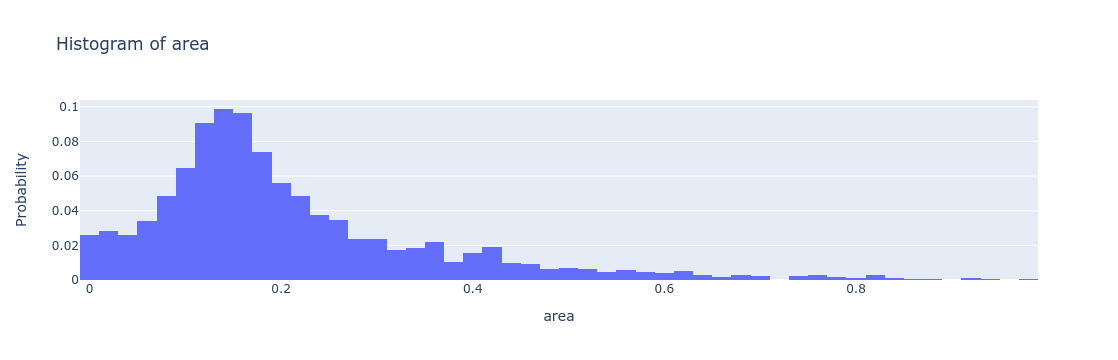

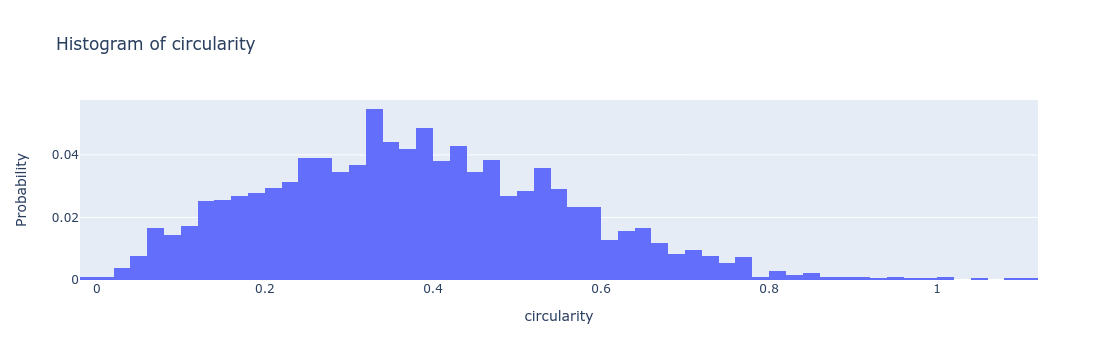

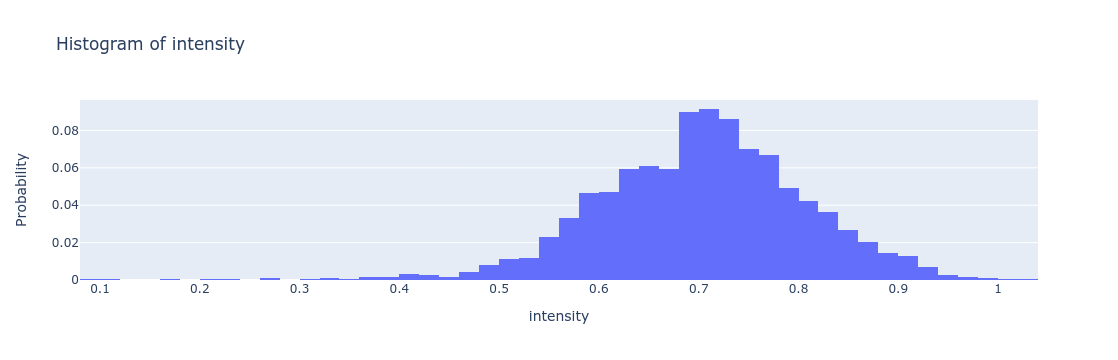

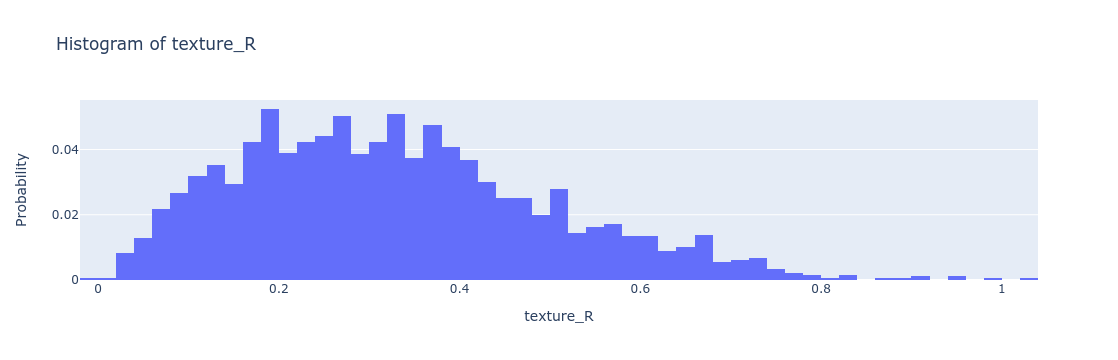

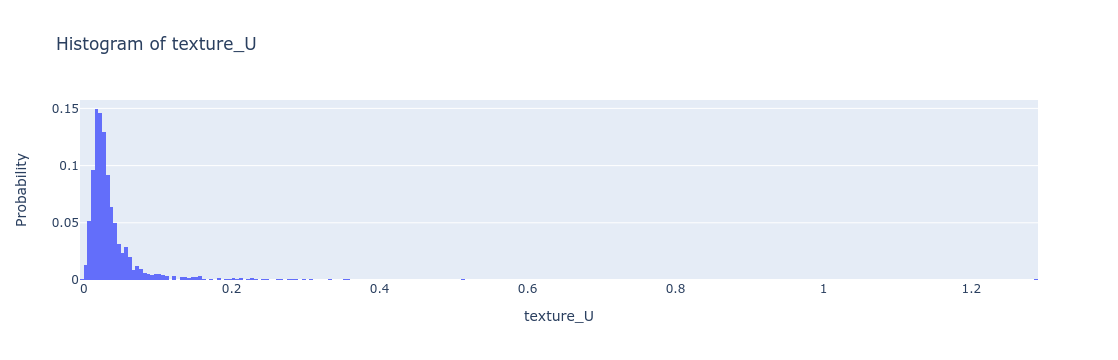

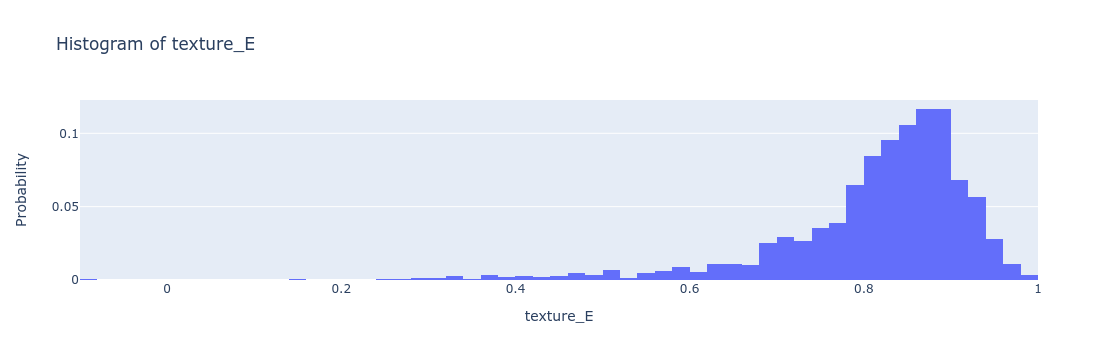

In [6]:
features = X_norm.columns

for i, feature in enumerate (features):
    fig = go.Figure()
    
    fig.add_trace(go.Histogram(x=X_norm.iloc[:,i].values, histnorm='probability'))
    
    fig.update_layout(
        title_text='Histogram of ' + feature, # title of plot
        xaxis_title_text=feature, # xaxis label
        yaxis_title_text='Probability', # yaxis label
    )
    fig.show()

## Select nuclei with high circularity

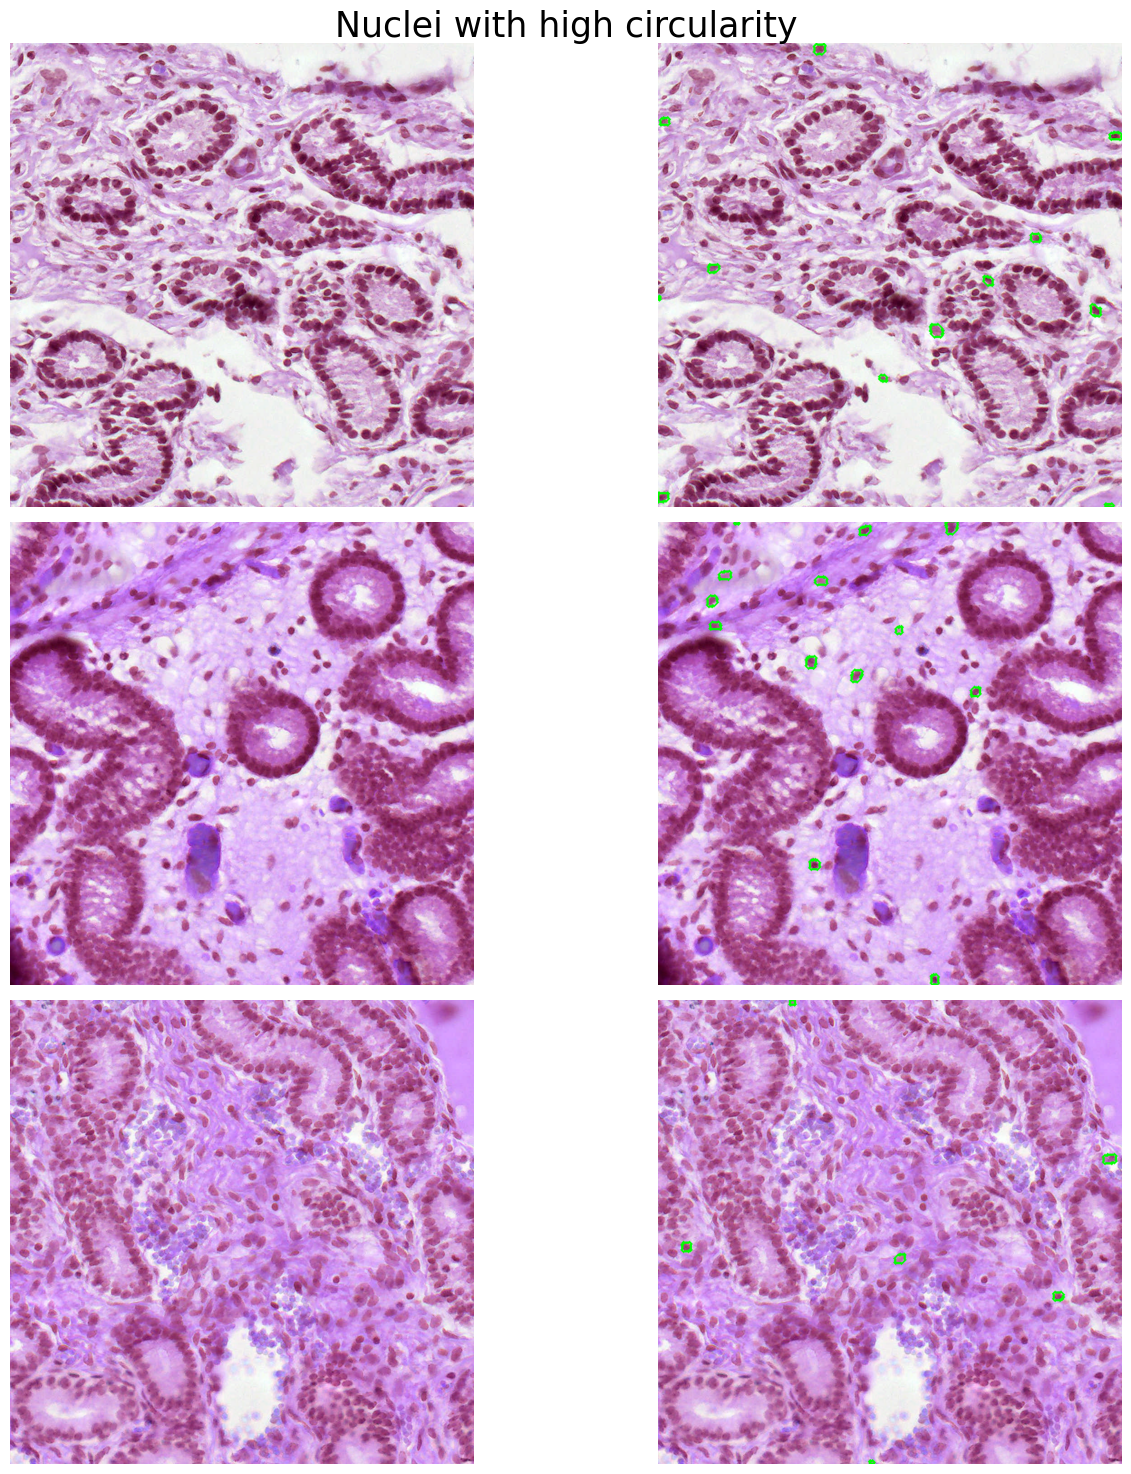

In [7]:
# Threshold to select nuclei with greater circularity
percentile = 90

# Select 3 images that contain nuclei with circularity greater than the percentile choosen
candidates_name = nuclei_df[nuclei_df['circularity']>np.percentile(nuclei_df['circularity'],percentile)]['image_name']
selected_images = np.random.choice(np.unique(candidates_name), 3, replace=False)

# Load images
images = [cv2.imread(os.path.join(PATH_TO_TEST_IMAGES, image_name)) for image_name in selected_images]

# Mark in the images the nuclei with high circularity
nuclei_high_circularity(images, percentile, nuclei_df, selected_images)

## Plot normalize features two by two

/home/sofia/Documents/FING/Proyecto/clasificacion_de_nucleos/WBC_Feature/venv/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning:

The figure layout has changed to tight



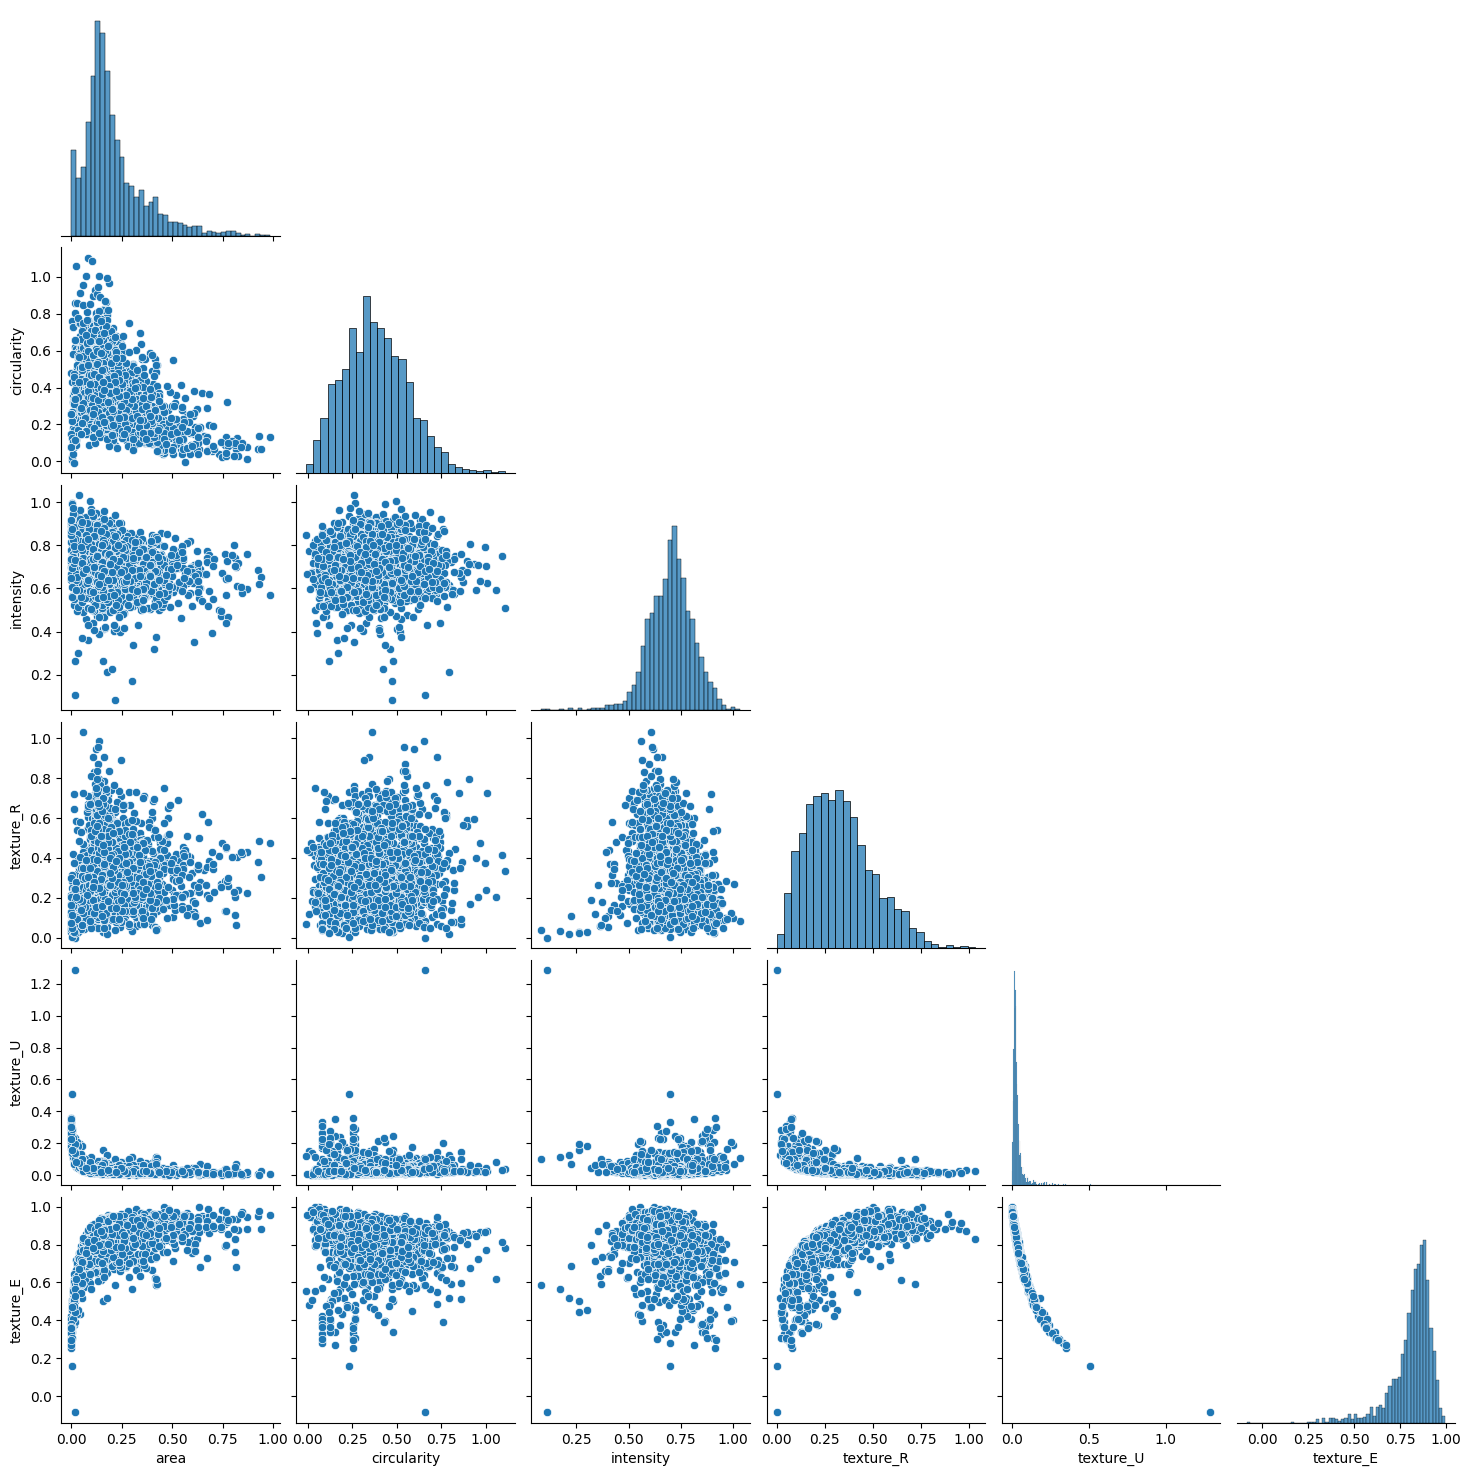

In [8]:
sns.pairplot(X_norm, corner=True)

## Load k-means pretrained model and run prediction over test dataset

In [9]:
kmeans_path = '/home/sofia/Documents/FING/Proyecto/clasificacion_de_nucleos/nuclei_classification/kmeans_5'
model = joblib.load(os.path.join(kmeans_path,'kmeans_5.joblib'))
prediction = model.predict(X_norm.values)

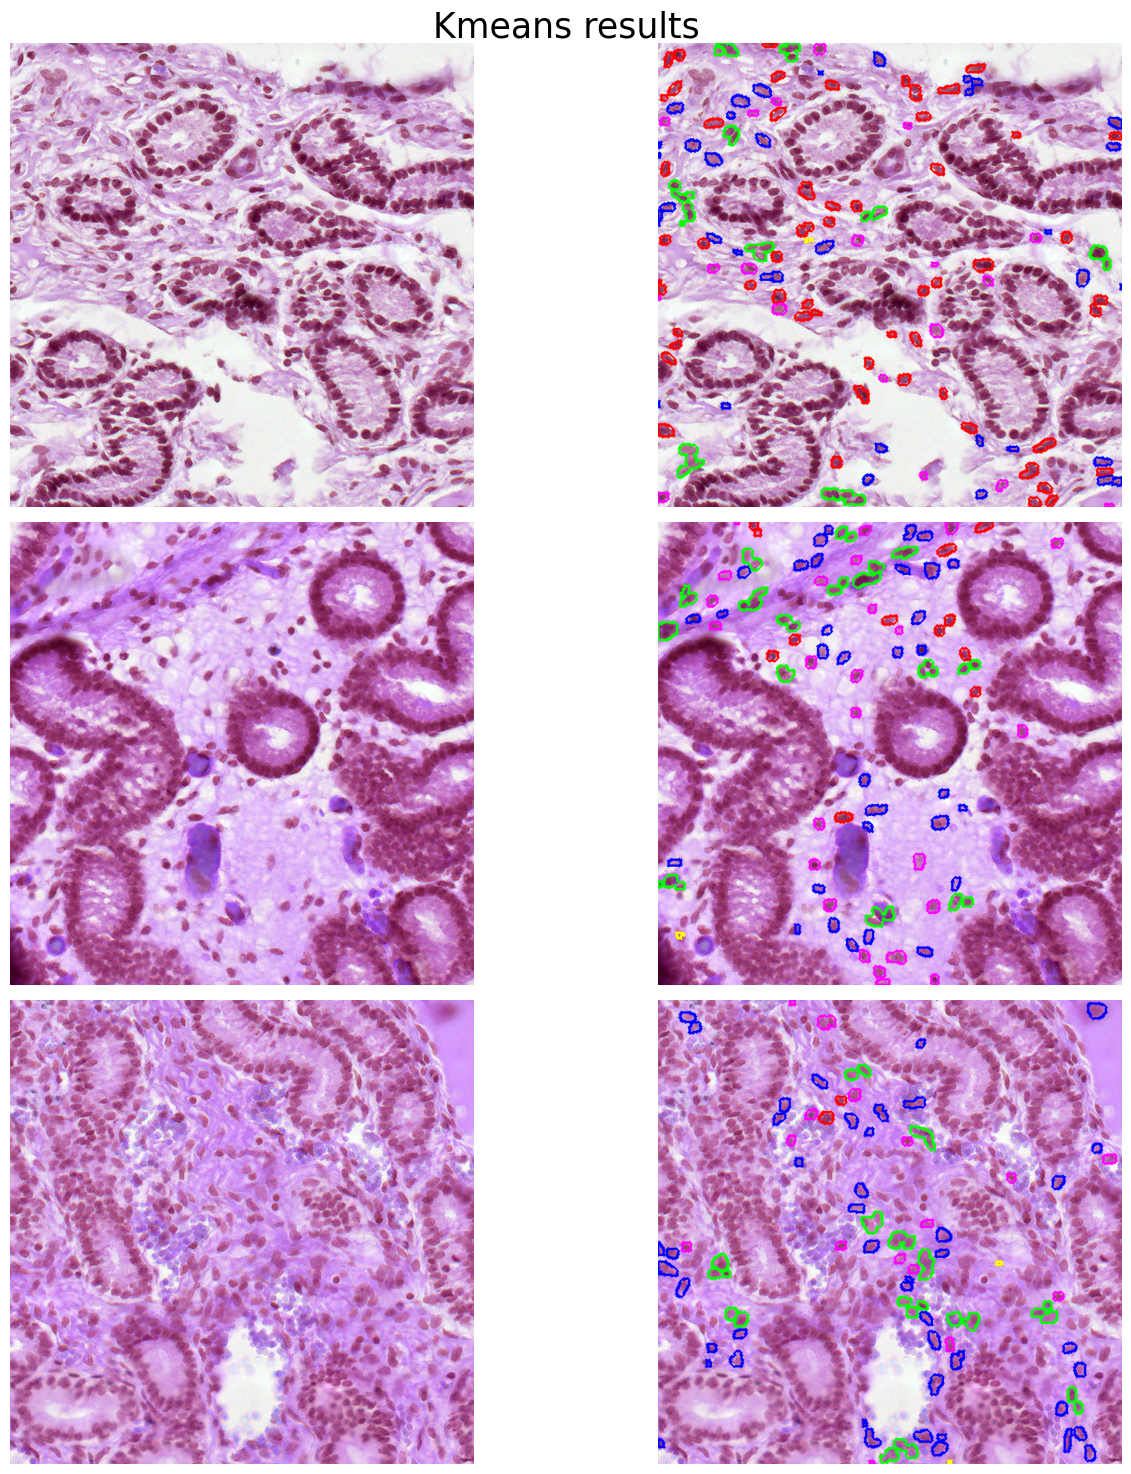

In [10]:
plot_results_kmeans(images, nuclei_df, selected_images, prediction)